In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda.amp import GradScaler, autocast
import shutil

# paths
dataset_dir = 'dataset'
output_folder = "split_dataset"
train_folder = os.path.join(output_folder, "train")
val_folder = os.path.join(output_folder, "val")
test_folder = os.path.join(output_folder, "test")

# config
class CONFIG:
    IMAGE_HEIGHT = 224
    IMAGE_WIDTH = 224
    CHANNELS = 3
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    N_CLASSES = len(os.listdir(dataset_dir))
    BATCH_SIZE = 32
    N_EPOCHS = 50
    PATIENCE_EPOCHS = 5
    LR = 0.001
    L2 = 0.0001
    DROPOUT = 0.3
    PATIENCE_SCHEDULER = 3
    MIN_VALUE_ACCURACY = 80
    MODEL_PATH = "best_model.pth"



# Data transformations (enhanced augmentation for better accuracy)
transform = transforms.Compose([
    transforms.Resize((CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH)),
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.RandomRotation(degrees=30),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def copy_images(subset, target_folder, dataset):
    # original dataset class names
    class_names = dataset.classes
    
    # create folder for each class
    for class_name in class_names:
        os.makedirs(os.path.join(target_folder, class_name), exist_ok=True)
    
    # copy image
    for idx in subset.indices:
        img_path, label = dataset.samples[idx]
        class_name = class_names[label]
        base_name = os.path.basename(img_path)
        dst_path = os.path.join(target_folder, class_name, base_name)
        
        if not os.path.exists(img_path):
            print(f"Warning: File not found - {img_path}. Skipping.")
            continue
        
        try:
            shutil.copy(img_path, dst_path)
        except Exception as e:
            print(f"Error copying file {img_path}: {e}")

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
# check if the split dataset already exists
if os.path.exists(train_folder) and os.path.exists(val_folder) and os.path.exists(test_folder):
    print("Loading pre-split dataset...")
    train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
    val_dataset = datasets.ImageFolder(root=val_folder, transform=transform)
    test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)
else:
    print("Splitting and saving dataset...")
    dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)
    
    # Split into train, validation, test
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)
    
    # copy images
    copy_images(train_dataset, train_folder, dataset)
    print(f"Training set copied to {train_folder}")
    copy_images(val_dataset, val_folder, dataset)
    print(f"Validation set copied to {val_folder}")
    copy_images(test_dataset, test_folder, dataset)
    print(f"Test set copied to {test_folder}")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)



Loading pre-split dataset...


C:\Users\sayfp\AppData\Local\Temp\ipykernel_7552\1399068769.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\sayfp\AppData\Local\Temp\ipykernel_7552\1399068769.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision


Epoch 1/50
Train Loss: 1.1940 | Train Accuracy: 65.37%
Validation Loss: 0.8142 | Validation Accuracy: 79.11%
Validation accuracy 79.1139 did not reach minimum 80.0000. Not saving.
Epoch 2/50
Train Loss: 0.7179 | Train Accuracy: 78.07%
Validation Loss: 0.6470 | Validation Accuracy: 79.11%
Validation accuracy 79.1139 did not reach minimum 80.0000. Not saving.
Epoch 3/50
Train Loss: 0.5417 | Train Accuracy: 84.10%
Validation Loss: 0.5494 | Validation Accuracy: 82.91%
Validation accuracy improved (82.911392 --> 82.911392). Saving model...
Epoch 4/50
Train Loss: 0.4978 | Train Accuracy: 84.74%
Validation Loss: 0.5068 | Validation Accuracy: 81.96%
EarlyStopping counter: 1 out of 5
Epoch 5/50
Train Loss: 0.4324 | Train Accuracy: 87.65%
Validation Loss: 0.5807 | Validation Accuracy: 81.65%
EarlyStopping counter: 2 out of 5
Epoch 6/50
Train Loss: 0.4218 | Train Accuracy: 86.59%
Validation Loss: 0.5191 | Validation Accuracy: 86.39%
Validation accuracy improved (86.392405 --> 86.392405). Saving m

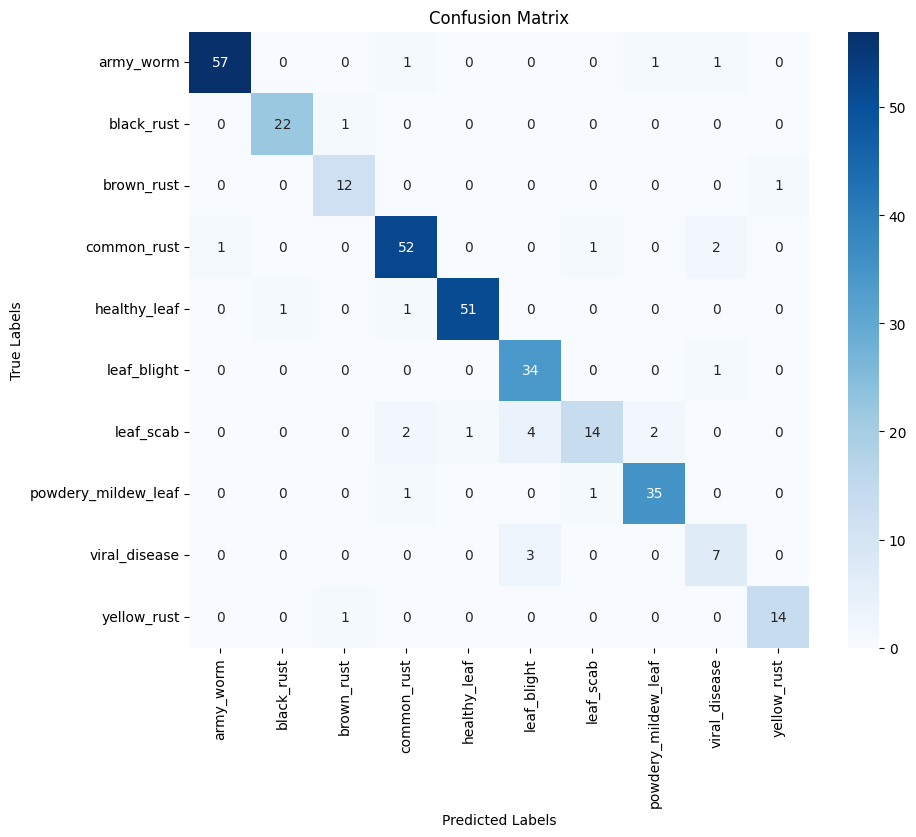

In [ ]:
# EfficientNet-B0 model
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model.classifier = nn.Sequential(
    nn.Dropout(p=CONFIG.DROPOUT, inplace=True),
    nn.Linear(model.classifier[1].in_features, CONFIG.N_CLASSES, bias=True)
)
model.to(CONFIG.DEVICE)

# Mixed Precision Training (for faster computation)
scaler = GradScaler()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=CONFIG.LR, weight_decay=CONFIG.L2)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=CONFIG.PATIENCE_SCHEDULER)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=0, verbose=False, min_delta=0, path=CONFIG.MODEL_PATH, min_val_acc=0):
        self.patience = patience
        self.verbose = verbose
        self.min_delta = min_delta
        self.path = path
        self.min_val_acc = min_val_acc
        self.counter = 0
        self.best_score = None
        self.early_stop = False
    
    def __call__(self, val_accuracy):
        if val_accuracy < self.min_val_acc:
            if self.verbose:
                print(f"Validation accuracy {val_accuracy:.4f} did not reach minimum {self.min_val_acc:.4f}. Not saving.")
            return
        score = val_accuracy
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(score)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(score)
            self.counter = 0
    
    def save_checkpoint(self, score):
        if self.verbose:
            print(f"Validation accuracy improved ({self.best_score:.6f} --> {score:.6f}). Saving model...")
        torch.save(model.state_dict(), self.path)

# Training function (with mixed precision)
def train_model(model, data_loader, criterion, optimizer, device, scaler):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast():  # Enable mixed precision
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
    avg_loss = train_loss / len(data_loader)
    train_accuracy = 100 * train_correct / train_total
    return avg_loss, train_accuracy

# Evaluation function
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    avg_loss = val_loss / len(data_loader)
    val_accuracy = 100 * val_correct / val_total
    scheduler.step(avg_loss)
    return avg_loss, val_accuracy, all_labels, all_preds

# Training
train_accuracies, val_accuracies, train_losses, val_losses = [], [], [], []
early_stopping = EarlyStopping(patience=CONFIG.PATIENCE_EPOCHS, verbose=True, min_val_acc=CONFIG.MIN_VALUE_ACCURACY, path=CONFIG.MODEL_PATH)

for epoch in range(CONFIG.N_EPOCHS):
    train_loss, train_accuracy = train_model(model, train_loader, criterion, optimizer, CONFIG.DEVICE, scaler)
    val_loss, val_accuracy, _, _ = evaluate_model(model, val_loader, criterion, CONFIG.DEVICE)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{CONFIG.N_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")
    
    early_stopping(val_accuracy)
    if early_stopping.early_stop:
        print("Early stopping activated. Stopping training.")
        break



#  report
report = classification_report(test_labels, test_preds, target_names=train_dataset.dataset.classes if hasattr(train_dataset, 'dataset') else train_dataset.classes)
print("==================")
print("Classification Report:\n", report)


test_loss, test_accuracy, test_labels, test_preds = evaluate_model(model, test_loader, criterion, CONFIG.DEVICE)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")


# confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.dataset.classes if hasattr(train_dataset, 'dataset') else train_dataset.classes, yticklabels=train_dataset.dataset.classes if hasattr(train_dataset, 'dataset') else train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
